In [1]:
from numpy import load
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K

In [2]:
#Loading arrays from disk
def load_arrays(pathx, pathy):
    dict_data_x = load(pathx)
    dict_data_y = load(pathy)
    x = dict_data_x['arr_0']
    y = dict_data_y['arr_0']
    return x, y

In [36]:
#Function for plotting training afterwards
def plot_training(H):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

In [3]:
#Load the arrays
x, y = load_arrays("data_2500_samples/data_x_2500.npz", "data_2500_samples/data_y_2500.npz")

In [4]:
#Check shapes of the arrays
print(x.shape)
print(y.shape)

(5000, 2, 123, 1650, 1)
(5000, 1)


In [5]:
#Split the dataset randomly
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3750, 2, 123, 1650, 1)
(3750, 1)
(1250, 2, 123, 1650, 1)
(1250, 1)


In [7]:
#Preprocessing
x_train = x_train / 255.
x_test = x_test / 255.

In [78]:
def build_siamese_model(input_shape):
    
    inputs = keras.layers.Input(input_shape)
    
    x = keras.layers.Conv2D(16, (2,2), activation="relu")(inputs)
    x = keras.layers.MaxPool2D(2,2)(x)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Conv2D(32, (2,2), activation="relu")(x)
    x = keras.layers.MaxPool2D(2,2)(x)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Conv2D(64, (2,2), activation="relu")(x)
    x = keras.layers.MaxPool2D(2,2)(x)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Conv2D(128, (2,2), activation="relu")(x)
    x = keras.layers.MaxPool2D(2,2)(x)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Conv2D(256, (2,2), activation="relu")(x)
    x = keras.layers.MaxPool2D(2,2)(x)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Flatten()(x)
    
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    outputs = keras.layers.Dense(64, activation="relu")(x)
    
    model = keras.models.Model(inputs, outputs)
    
    return model

In [79]:
input_dim = (x_train.shape[2:])
base_network = build_siamese_model(input_dim)

In [80]:
img_a = keras.layers.Input(shape=input_dim)
img_b = keras.layers.Input(shape=input_dim)

In [81]:
feat_vec_a = base_network(img_a)
feat_vec_b = base_network(img_b)

In [82]:
base_network.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 123, 1650, 1)]    0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 122, 1649, 16)     80        
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 61, 824, 16)       0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 61, 824, 16)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 60, 823, 32)       2080      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 30, 411, 32)       0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 30, 411, 32)       0  

In [83]:
def euclidian_distance(vects):
    x, y = vects
    distance = K.sqrt(K.sum(K.square(x-y), axis=1, keepdims=True))
    return distance

In [84]:
def euclidian_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [85]:
distance = keras.layers.Lambda(euclidian_distance, output_shape=euclidian_output_shape)([feat_vec_a, feat_vec_b])

In [86]:
model = keras.models.Model(inputs=[img_a, img_b], outputs=distance)

In [87]:
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [90]:
history=model.fit([x_train[:, 0], x_train[:, 1]], y_train, validation_data=([x_test[:, 0], x_test[:, 1]], y_test), epochs=10, batch_size=32)

Epoch 1/10
118/118 [==============================] - 11s 89ms/step - loss: 0.7212 - accuracy: 0.5056 - val_loss: 8.0333 - val_accuracy: 0.4792
Epoch 2/10
118/118 [==============================] - 9s 76ms/step - loss: 0.7282 - accuracy: 0.4965 - val_loss: 8.0333 - val_accuracy: 0.4792
Epoch 3/10
118/118 [==============================] - 9s 76ms/step - loss: 0.7263 - accuracy: 0.5091 - val_loss: 8.0333 - val_accuracy: 0.4792
Epoch 4/10
118/118 [==============================] - 9s 76ms/step - loss: 0.7239 - accuracy: 0.5003 - val_loss: 8.0333 - val_accuracy: 0.4792
Epoch 5/10
118/118 [==============================] - 9s 76ms/step - loss: 0.7328 - accuracy: 0.4840 - val_loss: 8.0333 - val_accuracy: 0.4792
Epoch 6/10
118/118 [==============================] - 9s 76ms/step - loss: 0.7272 - accuracy: 0.5024 - val_loss: 8.0333 - val_accuracy: 0.4792
Epoch 7/10
118/118 [==============================] - 9s 76ms/step - loss: 0.7267 - accuracy: 0.4949 - val_loss: 8.0333 - val_accuracy: 0.479

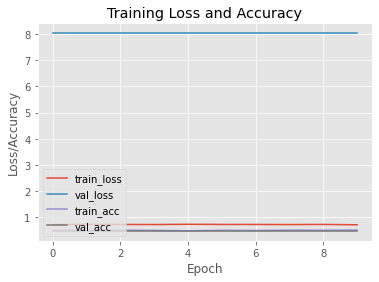

In [91]:
plot_training(history)